In [2]:
import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, Dense, TimeDistributed
from tensorflow.keras.optimizers import RMSprop

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

### Import Data

In [3]:
df = pd.read_csv(r'.\data\stock_prices_sample.csv')
df = df[df.TICKER != 'GEF']
df = df[df.TYPE != 'Intraday']
df.reset_index(drop = True, inplace =True)

### Defining Inputs

In [4]:
TRAIN_SPLIT=700

LOOK_BACK_WINDOW = 90
NUM_OF_FUTURE_PREDICTION = 30


BATCH_SIZE = 256
EPOCHS = 100

### Data Preprocessing

#### $Input Dataset$

In [5]:
input_features_considered = ["OPEN", "HIGH", "LOW", "CLOSE"]
input_features = df[input_features_considered]
input_data = input_features.values
# normalize the dataset
dataset_scaler = MinMaxScaler(feature_range=(0, 1))
dataset = dataset_scaler.fit_transform(input_data)

#### $Target Dataset$

In [6]:
target_features_considered = ["OPEN", "CLOSE"]
target_features = df[target_features_considered]
target_data = target_features.values
# normalize the dataset
target_scaler = MinMaxScaler(feature_range=(0, 1))
target = target_scaler.fit_transform(target_data)

In [7]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size):
    data = []
    labels = []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        data.append(dataset[indices])
        labels.append(target[i:i+target_size])
    return np.array(data), np.array(labels)

In [8]:
x_train, y_train = multivariate_data(dataset=dataset
                                     , target=target
                                     , start_index=0
                                     , end_index=TRAIN_SPLIT
                                     , history_size=LOOK_BACK_WINDOW
                                     , target_size=NUM_OF_FUTURE_PREDICTION)

x_val, y_val = multivariate_data(dataset=dataset
                                 , target=target
                                 , start_index=TRAIN_SPLIT
                                 , end_index=None
                                 , history_size=LOOK_BACK_WINDOW
                                 , target_size=NUM_OF_FUTURE_PREDICTION)

print("shape of x_train:", x_train.shape)
print("shape of y_train:", y_train.shape)
print("shape of x_val:", x_val.shape)
print("shape of y_val:", y_val.shape)

shape of x_train: (610, 90, 4)
shape of y_train: (610, 30, 2)
shape of x_val: (175, 90, 4)
shape of y_val: (175, 30, 2)


### RNN LSTM Encoder & Decoder Network

In [9]:
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=x_train.shape[-2:]))
model.add(RepeatVector(y_train.shape[1]))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(128, activation='relu')))
model.add(TimeDistributed(Dense(y_train.shape[2])))

model.compile(optimizer=RMSprop(clipvalue=1.0), loss='mse')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Model Trining

In [10]:
model_history = model.fit(x=x_train, y=y_train
                          , epochs=EPOCHS
                          , batch_size=BATCH_SIZE
                          , validation_data=(x_val, y_val))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 610 samples, validate on 175 samples
Epoch 1/100
610/610 [==============================] - 4s 7ms/sample - loss: 0.1292 - val_loss: 0.0775
Epoch 2/100
610/610 [==============================] - 1s 2ms/sample - loss: 0.0917 - val_loss: 0.0863
Epoch 3/100
610/610 [==============================] - 1s 2ms/sample - loss: 0.0428 - val_loss: 0.0611
Epoch 4/100
610/610 [==============================] - 1s 2ms/sample - loss: 0.0267 - val_loss: 0.0371
Epoch 5/100
610/610 [==============================] - 2s 3ms/sample - loss: 0.0159 - val_loss: 0.0322
Epoch 6/100
610/610 [==============================] - 1s 2ms/sample - loss: 0.0144 - val_loss: 0.0303
Epoch 7/100
610/610 [==============================] - 1s 2ms/sample - loss: 0.0132 - val_loss: 0.0338
Epoch 8/100
610/610 [==============================] - 1s 2ms/sample - loss: 0.0134 - val_loss: 0.0299
Epoch 9/100
610/610 [===============

610/610 [==============================] - 1s 2ms/sample - loss: 0.0049 - val_loss: 0.0221
Epoch 77/100
610/610 [==============================] - 1s 2ms/sample - loss: 0.0032 - val_loss: 0.0284
Epoch 78/100
610/610 [==============================] - 1s 2ms/sample - loss: 0.0035 - val_loss: 0.0219
Epoch 79/100
610/610 [==============================] - 1s 2ms/sample - loss: 0.0039 - val_loss: 0.0338
Epoch 80/100
610/610 [==============================] - 1s 2ms/sample - loss: 0.0042 - val_loss: 0.0223
Epoch 81/100
610/610 [==============================] - 1s 2ms/sample - loss: 0.0029 - val_loss: 0.0283
Epoch 82/100
610/610 [==============================] - 1s 2ms/sample - loss: 0.0030 - val_loss: 0.0216
Epoch 83/100
610/610 [==============================] - 1s 2ms/sample - loss: 0.0036 - val_loss: 0.0317
Epoch 84/100
610/610 [==============================] - 1s 2ms/sample - loss: 0.0045 - val_loss: 0.0222
Epoch 85/100
610/610 [==============================] - 2s 3ms/sample - loss:

### Train & CV Error (curve by epoch)

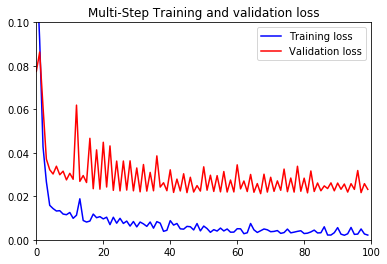

In [11]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.axis([0, EPOCHS, 0, 0.1])
    plt.title(title)
    plt.legend()
    plt.show()

plot_train_history(model_history, 'Multi-Step Training and validation loss')


### Visualizing Training & CV Fitting

#### $On Training Data$

In [12]:
if NUM_OF_FUTURE_PREDICTION == 1:
    # make predictions
    trainPredict = model.predict(x_train)
    trainPredict = trainPredict.reshape(trainPredict.shape[0], trainPredict.shape[2])
    # invert predictions
    trainPredict = target_scaler.inverse_transform(trainPredict)
    for i in range(target_data.shape[1]):
        name = "Feature: " + target_features_considered[i]
        plt.figure(figsize=(20, 10))
        plt.plot(target_data[LOOK_BACK_WINDOW:TRAIN_SPLIT,i], label='training data')
        plt.plot(trainPredict[:,i], label='fitted data model')
        plt.title(name)
        plt.grid(True)
        plt.legend()

#### $On CV Data$

In [13]:
if NUM_OF_FUTURE_PREDICTION == 1:
    # make predictions
    cvPredict = model.predict(x_val)
    cvPredict = cvPredict.reshape(cvPredict.shape[0], cvPredict.shape[2])
    # invert predictions
    cvPredict = target_scaler.inverse_transform(cvPredict)
    for i in range(target_data.shape[1]):
        name = "Feature: " + target_features_considered[i]
        plt.figure(figsize=(20, 10))
        plt.plot(target_data[TRAIN_SPLIT+LOOK_BACK_WINDOW:,i], label='CV data')
        plt.plot(cvPredict[:,i], label='fitted data model on CV data')
        plt.title(name)
        plt.grid(True)
        plt.legend()

### Model Summary

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               68096     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 128)           16512     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 2)             258       
Total params: 216,450
Trainable params: 216,450
Non-trainable params: 0
_________________________________________________________________


### Prediction

In [15]:
data_predict = dataset[-90:,:]
data_predict = data_predict.reshape((1, data_predict.shape[0], data_predict.shape[1]))
data_predict.shape
target_predicted = target_scaler.inverse_transform(model.predict(data_predict)[-1])

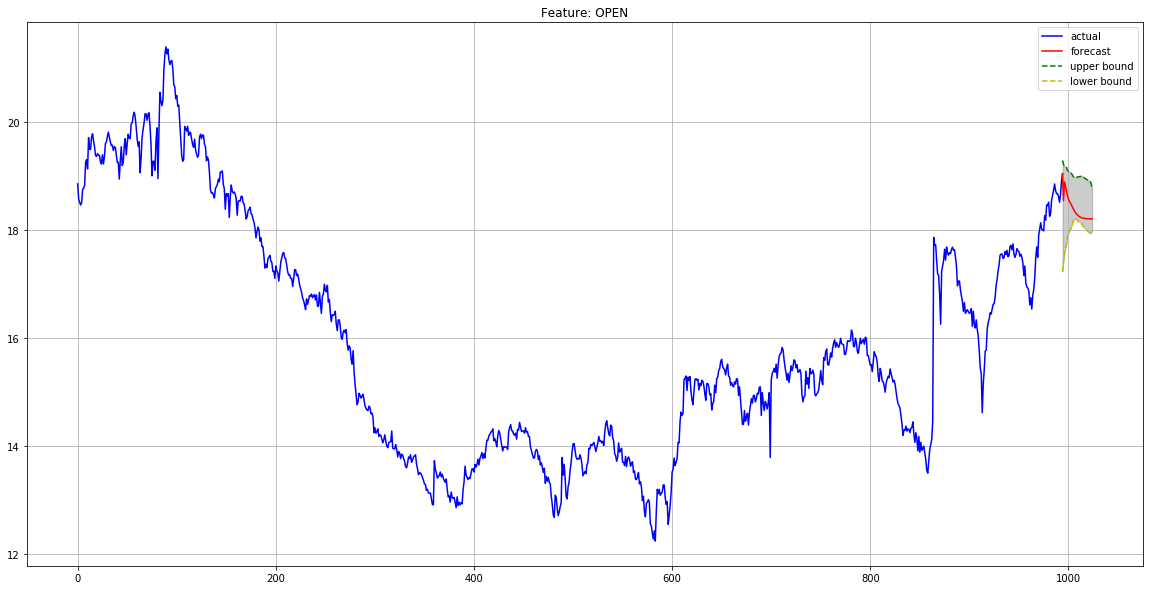

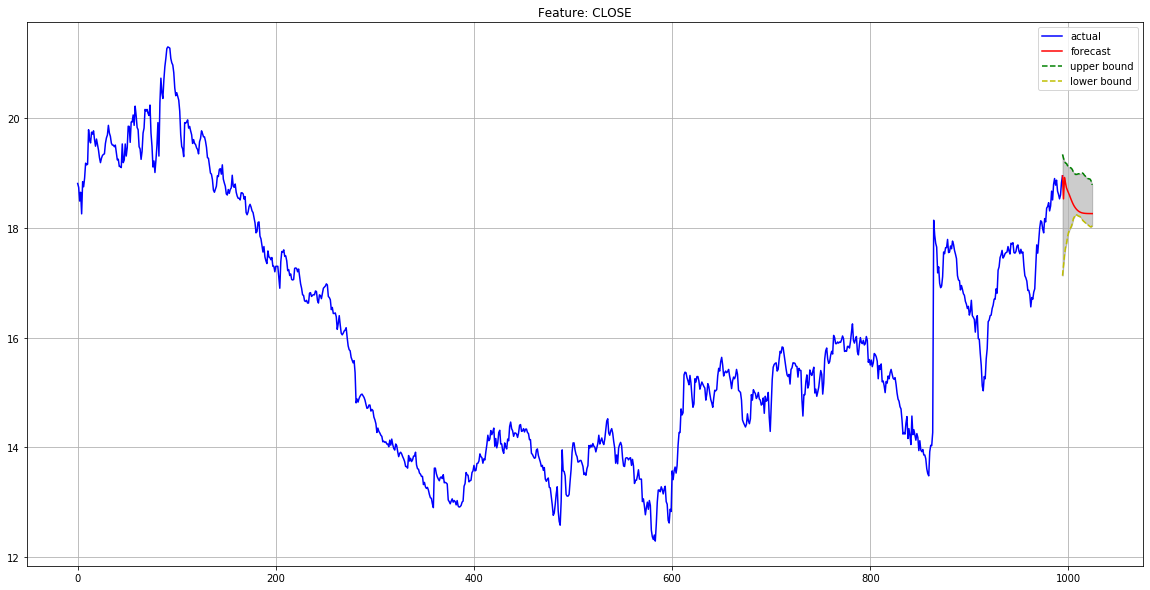

In [16]:
for i in range(target_data.shape[1]):
    name = "Feature: " + target_features_considered[i]
    df_out = pd.DataFrame(np.vstack([target_data,target_predicted]),columns=["OPEN", "CLOSE"])
    df_out["ISPredicted"]=np.hstack([np.zeros(target_data.shape[0]),np.ones(target_predicted.shape[0])])
    plt.figure(figsize=(20, 10))
    plt.plot(df_out.iloc[:target_data.shape[0],i], "b", label="actual")
    plt.plot(df_out.iloc[target_data.shape[0]-1:,i], "r", label="forecast")
    m = df_out.iloc[:,i].rolling(window=NUM_OF_FUTURE_PREDICTION).mean()
    s = df_out.iloc[:,i].rolling(window=NUM_OF_FUTURE_PREDICTION).std()
    ub = m + 1.96*s
    lb = m - 1.96*s
    plt.plot(ub[target_data.shape[0]-1:], 'g--', label='upper bound')
    plt.plot(lb[target_data.shape[0]-1:], 'y--', label='lower bound')
    plt.fill_between(df_out.index[target_data.shape[0]-1:]
                     , ub[target_data.shape[0]-1:]
                     , lb[target_data.shape[0]-1:], color='k', alpha=.2)
    plt.title(name)
    plt.grid(True)
    plt.legend();